In [1]:
import json

import pandas as pd

from math import pi
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display, clear_output

from sklearn.cluster import KMeans


In [2]:

def run_cluster(data, num_clusters=5):
    # create kmeans model
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(data)

    # find centers and labels
    centers = kmeans.cluster_centers_
    labels = kmeans.labels_

    # DataFrame of centroids
    centroids_df = pd.DataFrame(centers, columns=data.columns).T

    # print items in clusters
    clusters = {}
    for i in range(len(labels)):
        clusters[players[i]] = labels[i]

    for i in range(len(centers)):
        out = [k for k,v in clusters.items() if v==i]

        print('-'*30)
        print(f'cluster index: {i}')
        for item in out:
            print(item)
        print('\n')

#     centroids_df.to_csv('final_clusters.csv')
    return clusters, centroids_df


In [3]:
data = pd.read_csv('Data/nba_data_player.csv')
players = data.player.to_list()


In [4]:
# drop columns we don't want to use in k-means. We dropped mostly total statistics 
# in order to limit the degree to which our clusters were grouped by minutes played, as all total statistics
# are inherently correlated with minutes played, as the more minutes someone plays the more total statistics they accumulate
nba_data = data.drop(['Unnamed: 0', 'player', 'pos', 'team_id', 'age', 'mp', 'fg', 'fga','fg3',
 'fg3a','fg2',
 'fg2a','ft',
 'fta','orb',
 'drb',
 'trb',
 'ast',
 'stl',
 'blk',
 'tov',
 'pf',
 'pts',], axis=1)


In [5]:
num_clusters = 8
clusters, centroids_df = run_cluster(nba_data,  num_clusters)
# clusters.to_csv('clusters.csv')
centroids_df.to_csv('centroids.csv')

------------------------------
cluster index: 0
Steven Adams
LaMarcus Aldridge
Jarrett Allen
Deandre Ayton
Thomas Bryant
Clint Capela
Willie Cauley-Stein
John Collins
Anthony Davis
Andre Drummond
Joel Embiid
Derrick Favors
Taj Gibson
Rudy Gobert
Serge Ibaka
JaVale McGee
Paul Millsap
Jusuf Nurkic
Julius Randle
Karl-Anthony Towns
Myles Turner
Nikola Vucevic
Hassan Whiteside
DeAndre Jordan


------------------------------
cluster index: 1
Bam Adebayo
Marvin Bagley
Mo Bamba
Aron Baynes
Jordan Bell
Khem Birch
Bismack Biyombo
Dante Cunningham
Ed Davis
Cheick Diallo
Gorgui Dieng
Cristiano Felicio
Harry Giles
Montrezl Harrell
Willy Hernangomez
Richaun Holmes
Amir Johnson
Derrick Jones
Michael Kidd-Gilchrist
T.J. Leaf
Meyers Leonard
Kevon Looney
Alfonzo McKinnie
Larry Nance
Joakim Noah
Nerlens Noel
Kyle O'Quinn
Jahlil Okafor
Zaza Pachulia
Mason Plumlee
Jakob Poetl
Quincy Pondexter
Dwight Powell
Ivan Rabb
Mitchell Robinson
Domantas Sabonis
Daniel Theis
Ekpe Udoh
Robert Williams
Ante Zizic
Tyson 

In [6]:
player_df = data[['player', 'team_id']]

player_cluster_df = pd.DataFrame([clusters]).T.reset_index()
player_cluster_df = player_cluster_df.rename(columns={'index':'player', 0:'cluster'})

player_type_df = player_df.merge(player_cluster_df, on='player')
player_type_df.to_csv('player_type.csv')
player_type_df


,player,team_id,cluster
0,Alex Abrines,OKC,3
1,Jaylen Adams,ATL,3
2,Steven Adams,OKC,0
3,Bam Adebayo,MIA,1
4,LaMarcus Aldridge,SAS,0
...,...,...,...
419,Garrett Temple,LAC,7
420,Jonas Valanciunas,MEM,2
421,Christian Wood,NOP,3
422,Delon Wright,MEM,5


In [7]:
# headers = [f'cluster {x}' for x in range(8)]
headers = ['Good Starting Bigs, Few 3s', 'Solid Bench Bigs and Forwards', 'Okay Players With Injuries', 'Fringe NBA Players', 'Stars', 'Bench Spot-up Shooters', 'Solid Starters Good 3PT Shooters', 'Okay Role Players Solid 3PT Shooters']

teams_only_df = player_type_df.loc[player_type_df.team_id != 'TOT'].groupby(['team_id', 'cluster']).count()
max_cluster_size = max([max(teams_only_df.xs(i, level='cluster').player) for i in range(num_clusters)])


In [8]:
# number of players in each cluster
cluster_counts = player_type_df.groupby(['cluster'])['player'].count()

# calculate the number of players per cluster in the average team
avg_values = list(cluster_counts/30)
avg_values += avg_values[:1]

# list of angles for polar axis
angles = [n / float(num_clusters) * 2 * pi for n in range(num_clusters)]
angles += angles[:1]


with open('Data/team_colors.json', 'r') as f:
    team_colors = json.load(f)

def plot_cluster_count(headers, input_values, title='test', fill_color='k', edge_color='k'):
    values = input_values.copy()
    values += values[:1]

    # add plot and figure properties
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, polar=True)
    ax.set_facecolor('#d3d3d3')

    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    
    # set tick parameters
    plt.xticks(angles[:-1], headers)
    plt.yticks([y for y in range(max_cluster_size+1)])
    ax.set_rlabel_position(0)

    ax.set_ylim([0, max_cluster_size])

    ax.tick_params(axis='x', pad=25)
    ax.tick_params(axis='y', colors='#000000', labelsize=14)

    # plot average team overlay
    ax.plot(angles, avg_values, color='#fcfcfc', linewidth=3.5)
    ax.fill(angles, avg_values, facecolor='#eeeeee', alpha=0.5)
    
    # plot and fill area
    ax.plot(angles, values, color=edge_color, linewidth=3.5)
    ax.fill(angles, values, facecolor=fill_color, alpha=0.5)

    ax.set_title(title, y=1)
    plt.show()


def plot_team(team_abbr):
    # filter data for team
    team_cluster_df = player_type_df.loc[player_type_df.team_id == team_abbr]

    # counts the number of players per cluster
    cluster_group = team_cluster_df.groupby(['cluster']).count()['player']
    cluster_count = {f'cluster {x}': 0 for x in range(8)}
    for i in range(len(cluster_group)):
        cluster_count[f'cluster {cluster_group.index[i]}'] = cluster_group.values[i]

    # get team colors
    colors = [item for item in team_colors[team_abbr.upper()].values()][1:]
    team = team_colors[team_abbr.upper()]['team']

    # plots radar chart
    plot_cluster_count(headers, list(cluster_count.values()), f'player dist for {team}', colors[0], colors[1])


In [9]:
def plot_stats(ax, headers, values, title, edge_color='k', face_color='k'):
    values += values[:1]

    angles = [n / float(len(headers)) * 2 * pi for n in range(len(headers))]
    angles += angles[:1]

    ax.set_facecolor('#d3d3d3')

    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    
    # set tick parameters
    ax.set_xticklabels(headers)
    ax.set_rlabel_position(0)

    ax.set_ylim([0, 30])

    ax.tick_params(axis='x', pad=25)
    ax.tick_params(axis='y', colors='#000000', labelsize=14)

    # plot and fill area
    ax.plot(angles, values, color=edge_color, linewidth=3.5)
    ax.fill(angles, values, facecolor=face_color, alpha=0.5)

    ax.set_title(title, y=1)


In [10]:
stats = ['trb_per_g', 'ast_per_g', 'stl_per_g', 'blk_per_g', 'pts_per_g', 'per',
        'usg_pct', 'ws', 'vorp']

cluster_stats = centroids_df.loc[stats]

cluster_stats.loc[['vorp']] = cluster_stats.loc[['vorp']]*5


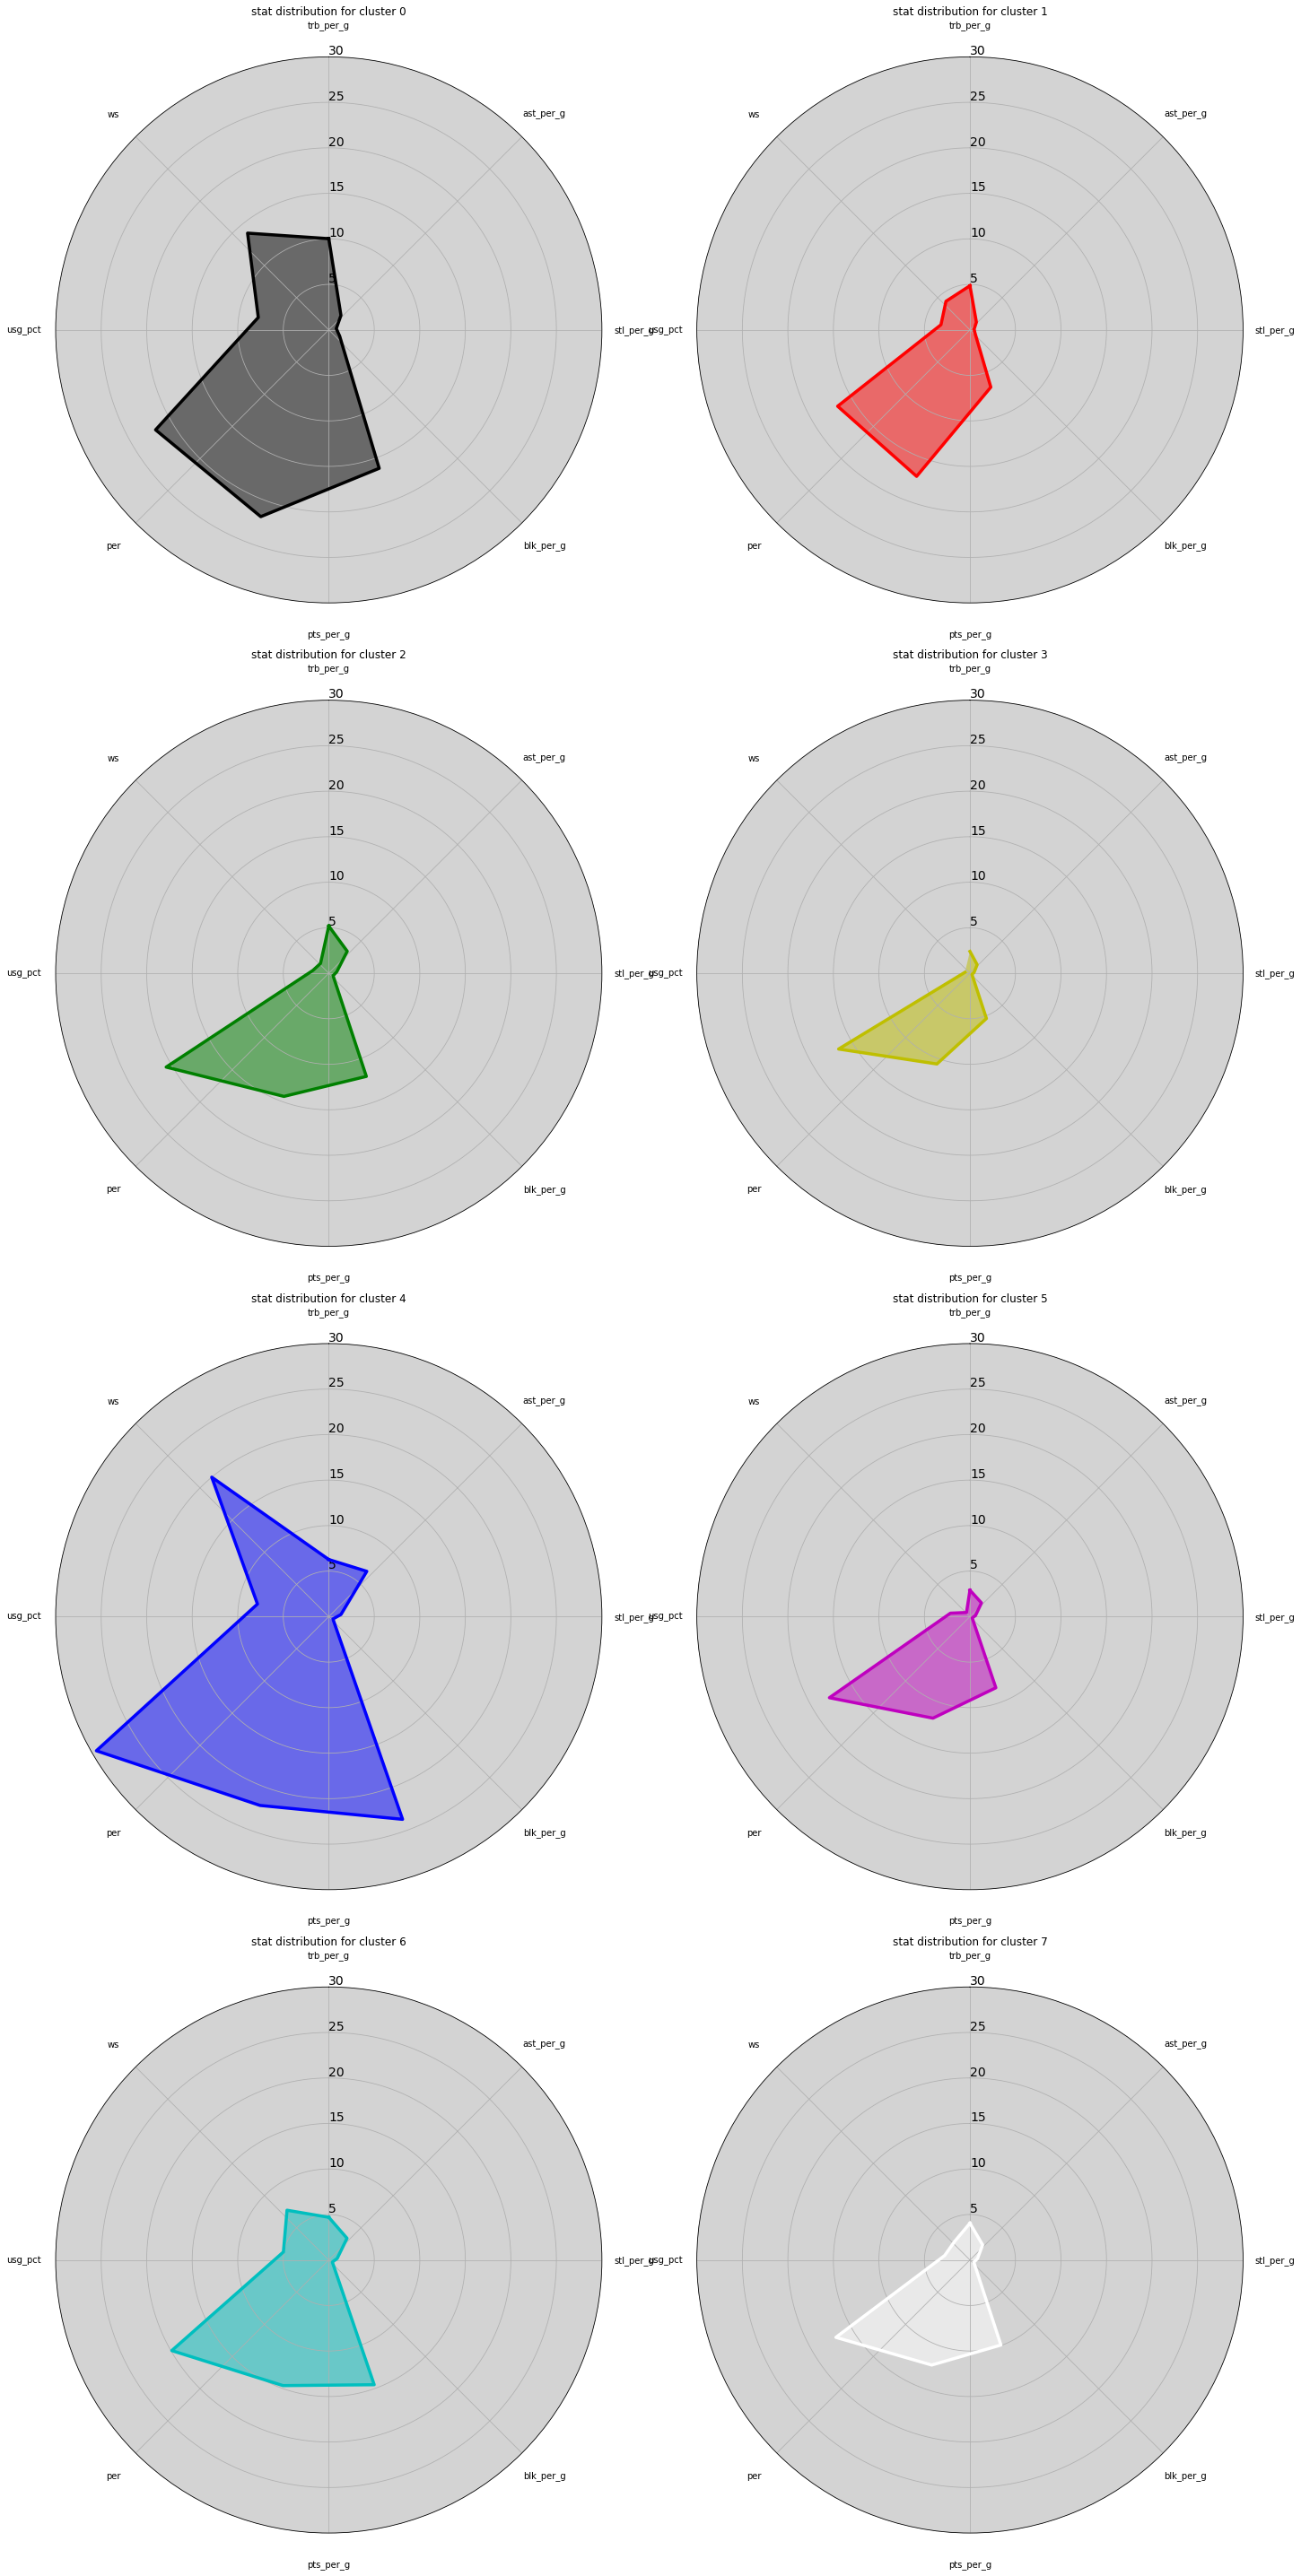

In [11]:
f = plt.figure(figsize=(20, 40))
ax0 = f.add_subplot(421, polar=True)
ax1 = f.add_subplot(422, polar=True)
ax2 = f.add_subplot(423, polar=True)
ax3 = f.add_subplot(424, polar=True)
ax4 = f.add_subplot(425, polar=True)
ax5 = f.add_subplot(426, polar=True)
ax6 = f.add_subplot(427, polar=True)
ax7 = f.add_subplot(428, polar=True)

plot_stats(ax0, stats, list(cluster_stats[0]), 'stat distribution for cluster 0', 'k', 'k')
plot_stats(ax1, stats, list(cluster_stats[1]), 'stat distribution for cluster 1', 'r', 'r')
plot_stats(ax2, stats, list(cluster_stats[2]), 'stat distribution for cluster 2', 'g', 'g')
plot_stats(ax3, stats, list(cluster_stats[3]), 'stat distribution for cluster 3', 'y', 'y')
plot_stats(ax4, stats, list(cluster_stats[4]), 'stat distribution for cluster 4', 'b', 'b')
plot_stats(ax5, stats, list(cluster_stats[5]), 'stat distribution for cluster 5', 'm', 'm')
plot_stats(ax6, stats, list(cluster_stats[6]), 'stat distribution for cluster 6', 'c', 'c')
plot_stats(ax7, stats, list(cluster_stats[7]), 'stat distribution for cluster 7', 'w', 'w')

f.tight_layout()

plt.show()


In [12]:
team_list = list(player_df.team_id.unique())
team_list.sort()

team_dropdown = widgets.Dropdown(
    options=team_list,
    value=team_list[0],
    disabled=False
)

display(team_dropdown)

def on_change(change):
    clear_output()
    display(team_dropdown)
    team_abbr = team_dropdown.value
    if change['name'] == 'value':
        plot_team(team_abbr)

team_dropdown.observe(on_change, type='change', names='value')


Dropdown(options=('ATL', 'BOS', 'BRK', 'CHI', 'CHO', 'CLE', 'DAL', 'DEN', 'DET', 'GSW', 'HOU', 'IND', 'LAC', '…